# Tutorial 4: Training a spiking neural network on a spiking dataset (Spiking Heidelberg Digits)

Manu Srinath Halvagal (https://zenkelab.org/team/) and Friedemann Zenke (https://fzenke.net)

For more details on surrogate gradient learning, please see:

> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-based optimization to spiking neural networks. IEEE Signal Process Mag 36, 51–63.
> https://ieeexplore.ieee.org/document/8891809 and https://arxiv.org/abs/1901.09948

> Cramer, B., Stradmann, Y., Schemmel, J., and Zenke, F. (2020). The Heidelberg Spiking Data Sets for the Systematic Evaluation of Spiking Neural Networks. IEEE Transactions on Neural Networks and Learning Systems 1–14.
> https://ieeexplore.ieee.org/document/9311226 and https://arxiv.org/abs/1910.07407"

Here we apply the model to train a spiking network to learn the Spiking Heidelberg Digits dataset (https://compneuro.net/posts/2019-spiking-heidelberg-digits/). This dataset uses a more sophisticated cochlear model to generate the spike data corresponding to audio recordings of spoken digits (examples below).

In [1]:
import os
import h5py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
from torch.utils import data

from utils import get_shd_dataset

In [2]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### Setup of the spiking dataset

In [3]:
# 1. Define a clear, absolute path in the Colab/Kaggle workspace
# Using '/content/data' for Colab or './data' for a general environment
cache_dir = "/content/data"
cache_subdir = "hdspikes"
target_dir = os.path.join(cache_dir, cache_subdir)

# 2. Ensure the directory exists
os.makedirs(target_dir, exist_ok=True)

# 3. Download the dataset to that specific directory
get_shd_dataset(cache_dir, cache_subdir)

# 4. Define the file paths explicitly
train_path = os.path.join(target_dir, 'shd_train.h5')
test_path = os.path.join(target_dir, 'shd_test.h5')

# 5. Open the files and access the data
if os.path.exists(train_path) and os.path.exists(test_path):
    train_file = h5py.File(train_path, 'r')
    test_file = h5py.File(test_path, 'r')

    # Assigning to variables
    # Note: These are HDF5 datasets; they act like arrays but stay on disk
    # until you index them (e.g., x_train[0:10])
    x_train = train_file['spikes']
    y_train = train_file['labels']
    x_test = test_file['spikes']
    y_test = test_file['labels']

    print("Success! Data is mapped and ready for training.")
    print(f"Training samples: {len(y_train)}")
    print(f"Testing samples:  {len(y_test)}")
else:
    print(f"Error: Files not found at {target_dir}")

Decompressing /content/data/hdspikes/shd_train.h5.gz
Available at: /content/data/hdspikes/shd_train.h5
Decompressing /content/data/hdspikes/shd_test.h5.gz
Available at: /content/data/hdspikes/shd_test.h5
Success! Data is mapped and ready for training.
Training samples: 8156
Testing samples:  2264


The code for learning the SHD dataset is nearly identical to what we have seen for the FashionMNIST dataset in the last two tutorials. An important difference is that, now, we have the input data already in the form of spikes. This is reflected in the sparse_data_generator below.

In order to use the data for learning with our spiking network, we also need to discretize the spike times into n_steps bins. Note the additional max_time argument (~1.4 for SHD) that forms the upper limit of the bins.

In [4]:
def sparse_data_generator_from_hdf5_spikes(X, y, batch_size, nb_steps, nb_units, max_time, shuffle=True):
    labels_ = np.array(y, dtype=int)
    number_of_batches = len(labels_) // batch_size
    sample_index = np.arange(len(labels_))

    if shuffle:
        np.random.shuffle(sample_index)

    for batch_idx in range(number_of_batches):
        batch_slice = sample_index[batch_idx * batch_size: (batch_idx + 1) * batch_size]

        # Extract spike times and units for this batch
        times = [X['times'][i] for i in batch_slice]
        units = [X['units'][i] for i in batch_slice]

        # Convert to sparse tensor format
        # Note: We use torch.int64 for indices and torch.float32 for values
        coo = []
        for i, (t, u) in enumerate(zip(times, units)):
            # Discretize time into bins
            t_bins = np.floor(t * (nb_steps - 1) / max_time).astype(int)

            # Filter spikes that fall outside the simulation window
            idx = np.where(t_bins < nb_steps)[0]

            # Create coordinate list: [batch_index, time_bin, unit_id]
            for j in idx:
                coo.append([i, t_bins[j], u[j]])

        coo = np.array(coo)
        i = torch.LongTensor(coo).t()
        v = torch.FloatTensor(np.ones(len(coo)))

        # Create the sparse tensor
        # Shape: (batch_size, nb_steps, nb_units)
        X_batch = torch.sparse_coo_tensor(i, v, torch.Size([batch_size, nb_steps, nb_units]))

        y_batch = torch.tensor(labels_[batch_slice], dtype=torch.long)

        yield X_batch, y_batch

### Setup of the spiking network model

Let's also now include recurrent weights in the hidden layer. This significantly improves performance on the SHD dataset .

In [5]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

In [6]:
from IPython.display import clear_output

def live_plot(loss):
    if len(loss) == 1:
        return
    clear_output(wait=True)
    ax = plt.figure(figsize=(3,2), dpi=150).gca()
    ax.plot(range(1, len(loss) + 1), loss)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.xaxis.get_major_locator().set_params(integer=True)
    sns.despine()
    plt.show()

## Training the network

In [7]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

run_snn is also changed now in order to include the recurrent input in the hidden layer computation.

In [8]:
def run_snn(inputs):
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    out = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
    h1_from_input = torch.einsum("abc,cd->abd", (inputs, w1))
    for t in range(nb_steps):
        h1 = h1_from_input[:,t] + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1
        new_mem =(beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)

        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [9]:
# 1. Define the Loss Function
# CrossEntropyLoss is standard for classification tasks
loss_fn = nn.CrossEntropyLoss()

# 2. Define Simulation Hyperparameters
# These values are standard for the SHD dataset tutorial
time_step = 1e-3
tau_mem = 10e-3
tau_syn = 5e-3

# Decay constants for the LIF neurons
alpha = np.exp(-time_step/tau_syn)
beta  = np.exp(-time_step/tau_mem)

# Dataset/Network dimensions
nb_inputs  = 700
nb_hidden  = 128
nb_outputs = 20
nb_steps   = 100
batch_size = 256
max_time   = 1.0

print(f"Hyperparameters set: alpha={alpha:.4f}, beta={beta:.4f}")

Hyperparameters set: alpha=0.8187, beta=0.9048


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

# 2. Initialize Weights (Standard for Tutorial 4)
# nb_inputs = 700 (SHD channels), nb_hidden = 128, nb_outputs = 20 (digits)
w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=1.0/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=1.0/np.sqrt(nb_hidden))

# Recurrent weights for the hidden layer
v1 = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(v1, mean=0.0, std=1.0/np.sqrt(nb_hidden))

# 3. Group them into the missing 'params' list
params = [w1, w2, v1]

def train(x_data, y_data, lr=2e-4, nb_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize your optimizer with your model parameters
    # (Assuming params is a list of your weights [w1, w2, v1, etc.])
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))

    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size, nb_steps, nb_inputs, max_time):
            # 1. Convert sparse to dense
            # 2. Move the input tensor to the GPU
            # 3. Move the labels to the GPU
            x_dense = x_local.to_dense().to(device)
            y_local = y_local.to(device)

            output, recs = run_snn(x_dense)

            # Loss calculation
            # (Ensure your loss function handles the device correctly)
            _, spks = recs
            m, _ = torch.max(output, 1)
            loss_val = loss_fn(m, y_local) # loss_fn should be defined earlier (e.g., nn.CrossEntropyLoss)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            local_loss.append(loss_val.item())

        mean_loss = np.mean(local_loss)
        print(f"Epoch {e}: loss={mean_loss:.5f}")
        loss_hist.append(mean_loss)

    return loss_hist


def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    # Ensure we use the same device as the weights
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size, nb_steps, nb_inputs, max_time, shuffle=False):
        inputs = x_local.to_dense().to(device)
        output, _ = run_snn(inputs)

        # Max over time dimension
        m, _ = torch.max(output, 1)
        # Argmax over output units
        _, am = torch.max(m, 1)

        # Compare to labels (move labels to CPU for numpy comparison)
        tmp = np.mean((y_local.to(device) == am).detach().cpu().numpy())
        accs.append(tmp)

    return np.mean(accs)

In [11]:
nb_epochs = 50

WARNING: Training for a large number of epochs could take a significant amount of time. Reduce the nb_epochs parameter as necessary.

In [12]:
loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=nb_epochs)

Epoch 0: loss=10.73182
Epoch 1: loss=4.71030
Epoch 2: loss=3.61557
Epoch 3: loss=3.22379
Epoch 4: loss=2.98580
Epoch 5: loss=2.68007
Epoch 6: loss=2.50184
Epoch 7: loss=2.36894
Epoch 8: loss=2.27869
Epoch 9: loss=2.24280
Epoch 10: loss=2.14941
Epoch 11: loss=2.13283
Epoch 12: loss=2.06125
Epoch 13: loss=2.01146
Epoch 14: loss=1.93551
Epoch 15: loss=1.82818
Epoch 16: loss=1.80684
Epoch 17: loss=1.74266
Epoch 18: loss=1.66589
Epoch 19: loss=1.65411
Epoch 20: loss=1.63864
Epoch 21: loss=1.58354
Epoch 22: loss=1.57260
Epoch 23: loss=1.52796
Epoch 24: loss=1.51527
Epoch 25: loss=1.50678
Epoch 26: loss=1.48573
Epoch 27: loss=1.43386
Epoch 28: loss=1.40279
Epoch 29: loss=1.39197
Epoch 30: loss=1.35008
Epoch 31: loss=1.31788
Epoch 32: loss=1.27739
Epoch 33: loss=1.24170
Epoch 34: loss=1.21228
Epoch 35: loss=1.19579
Epoch 36: loss=1.18162
Epoch 37: loss=1.15016
Epoch 38: loss=1.16043
Epoch 39: loss=1.11741
Epoch 40: loss=1.09932
Epoch 41: loss=1.06591
Epoch 42: loss=1.03871
Epoch 43: loss=1.039

In [13]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test)))

Training accuracy: 0.669
Test accuracy: 0.535


In [14]:
def get_mini_batch(x_data, y_data, shuffle=False):
    for ret in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size, nb_steps, nb_inputs, max_time, shuffle=shuffle):
        return ret

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_batch, y_batch = get_mini_batch(x_test, y_test)

# 3. Convert to dense AND move to the GPU
# This ensures x_batch and w1 are on the "same island" (cuda:0)
inputs = x_batch.to_dense().to(device)

output, other_recordings = run_snn(inputs)
mem_rec, spk_rec = other_recordings

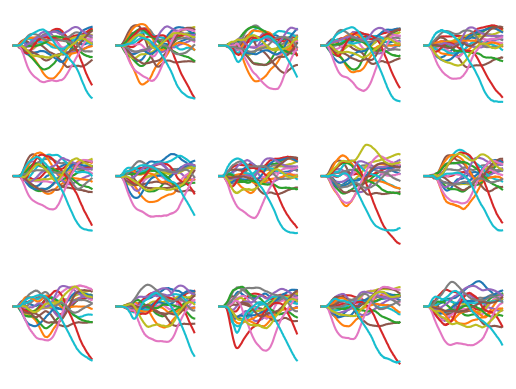

In [16]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

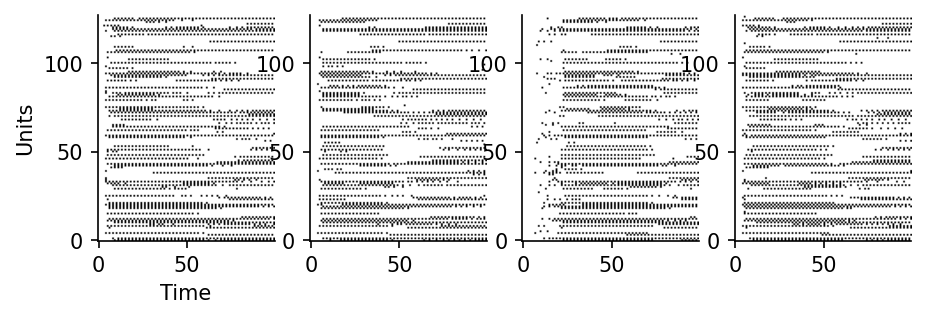

In [17]:
# Let's plot the hiddden layer spiking activity for some input stimuli
nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()

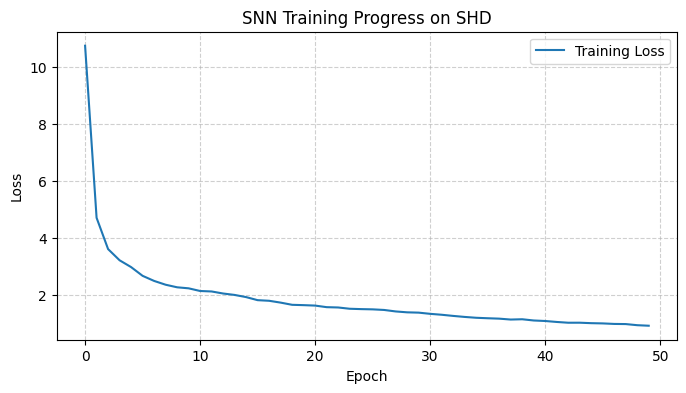

In [18]:
def plot_loss_history(loss_hist):
    plt.figure(figsize=(8, 4))
    plt.plot(loss_hist, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("SNN Training Progress on SHD")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_loss_history(loss_hist)

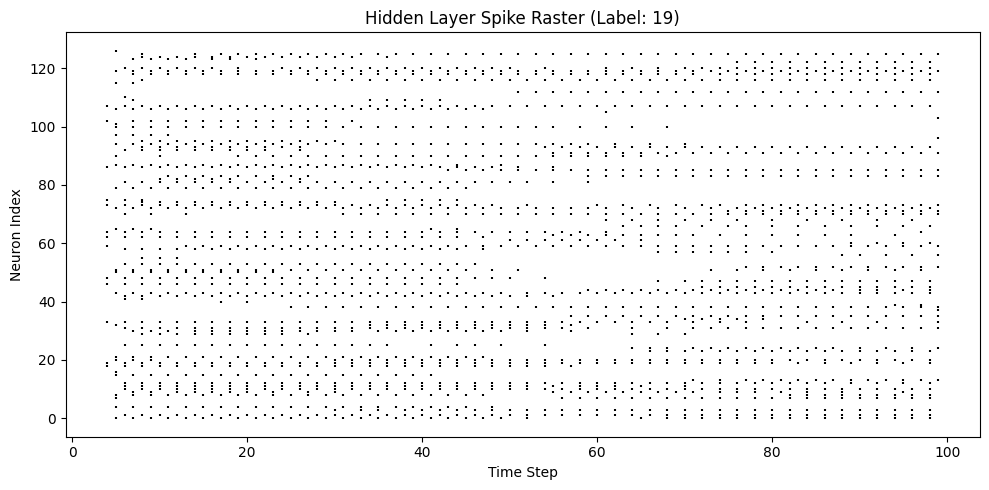

In [19]:
def plot_spike_raster(batch_idx=0):
    # Get a single sample from the test set
    x_local, y_local = next(iter(sparse_data_generator_from_hdf5_spikes(x_test, y_test, batch_size, nb_steps, nb_inputs, max_time)))
    output, recs = run_snn(x_local.to_dense().to(device))
    mem_rec, spk_rec = recs

    # spk_rec shape is (batch, time, neurons)
    # Pick the first sample in the batch and move to CPU
    spikes = spk_rec[batch_idx].detach().cpu().numpy()

    plt.figure(figsize=(10, 5))
    # Find coordinates of spikes (where value is 1)
    t_idx, n_idx = np.where(spikes > 0)
    plt.scatter(t_idx, n_idx, s=2, c="black", marker="|")
    plt.xlabel("Time Step")
    plt.ylabel("Neuron Index")
    plt.title(f"Hidden Layer Spike Raster (Label: {y_local[batch_idx]})")
    plt.tight_layout()
    plt.show()

plot_spike_raster()

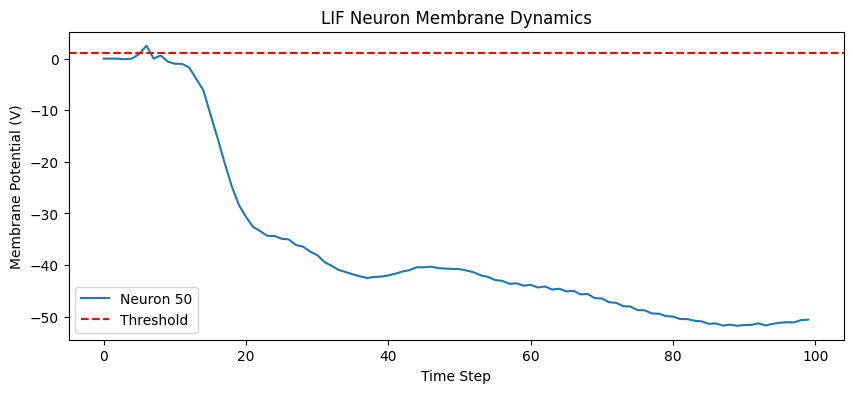

In [20]:
def plot_membrane_potentials(batch_idx=0, neuron_idx=0):
    x_local, y_local = next(iter(sparse_data_generator_from_hdf5_spikes(x_test, y_test, batch_size, nb_steps, nb_inputs, max_time)))
    output, recs = run_snn(x_local.to_dense().to(device))
    mem_rec, _ = recs

    # Extract potential for one specific neuron over time
    potentials = mem_rec[batch_idx, :, neuron_idx].detach().cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.plot(potentials, label=f"Neuron {neuron_idx}")
    plt.axhline(y=1.0, color='r', linestyle='--', label="Threshold")
    plt.xlabel("Time Step")
    plt.ylabel("Membrane Potential (V)")
    plt.title("LIF Neuron Membrane Dynamics")
    plt.legend()
    plt.show()

plot_membrane_potentials(neuron_idx=50)

We see that spiking in the hidden layer is quite sparse as in the previous Tutorial 3 because we used the same activity regularizer.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.